In [2]:
import torchvision
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Lambda, ToTensor


def download_dataset():
    mnist = torchvision.datasets.MNIST(root='./data/mnist', download=True)
    print('length of MNIST', len(mnist))
    id = 4
    img, label = mnist[id]
    print(img)
    print(label)

    # On computer with monitor
    # img.show()

    img.save('work_dirs/tmp.jpg')
    tensor = ToTensor()(img)
    print(tensor.shape)
    print(tensor.max())
    print(tensor.min())


def get_dataloader(batch_size: int):
    transform = Compose([ToTensor(), Lambda(lambda x: (x - 0.5) * 2)])
    dataset = torchvision.datasets.MNIST(root='./data/mnist',
                                         transform=transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


def get_img_shape():
    return (1, 28, 28)


if __name__ == '__main__':
    import os
    os.makedirs('work_dirs', exist_ok=True)
    download_dataset()

length of MNIST 60000
<PIL.Image.Image image mode=L size=28x28 at 0x7B44017B5130>
9
torch.Size([1, 28, 28])
tensor(1.)
tensor(0.)


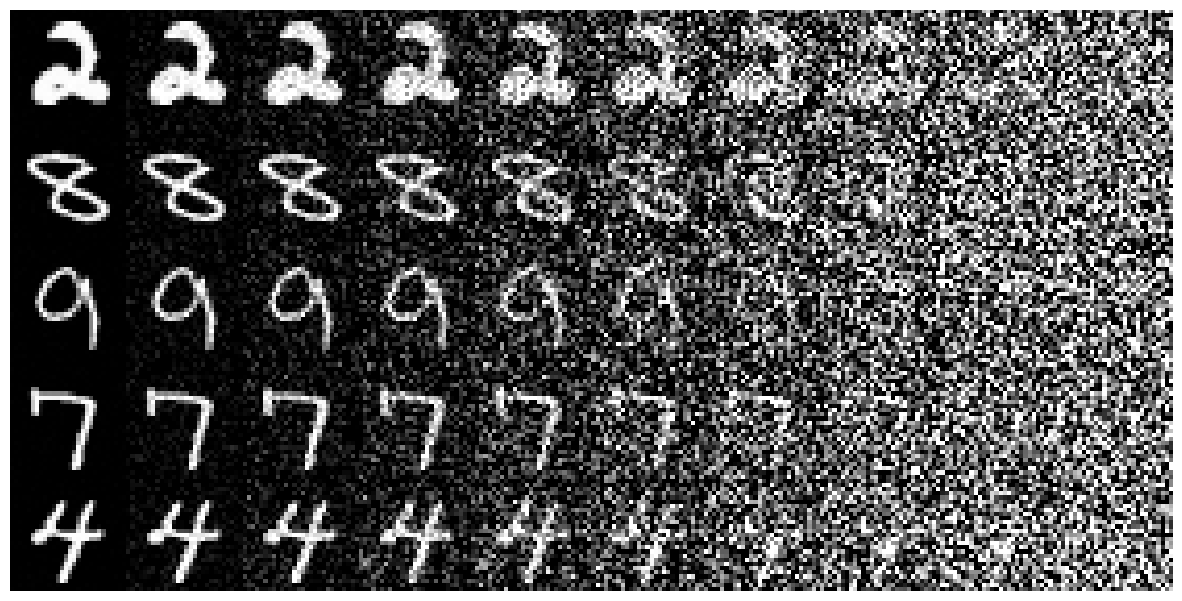

In [12]:
import torch


class DDPM():

    def __init__(self,
                 device,
                 n_steps: int,
                 min_beta: float = 0.0001,
                 max_beta: float = 0.02):
        betas = torch.linspace(min_beta, max_beta, n_steps).to(device)
        alphas = 1 - betas
        alpha_bars = torch.empty_like(alphas)
        product = 1
        for i, alpha in enumerate(alphas):
            product *= alpha
            alpha_bars[i] = product
        self.betas = betas
        self.n_steps = n_steps
        self.alphas = alphas
        self.alpha_bars = alpha_bars
        
        alpha_prev = torch.empty_like(alpha_bars)
        alpha_prev[1:] = alpha_bars[0:n_steps - 1]
        alpha_prev[0] = 1
        self.coef1 = torch.sqrt(alphas) * (1 - alpha_prev) / (1 - alpha_bars)
        self.coef2 = torch.sqrt(alpha_prev) * self.betas / (1 - alpha_bars)

    def sample_forward(self, x, t, eps=None):
        '''
            Args: 
                x: input tensor: image
                t: a step number
                eps: 
        self.alpha_bars: tensor([0.9999, 0.9996, 0.9991, 0.9984, 0.9975, 0.9964, 0.9951, 0.9936, 0.9919,
                0.9900, 0.9879, 0.9856, 0.9832, 0.9805, 0.9776, 0.9746, 0.9713, 0.9679,
                0.9643, 0.9606, 0.9566, 0.9525, 0.9482, 0.9437, 0.9390, 0.9342, 0.9292,
                0.9241, 0.9188, 0.9134, 0.9078, 0.9020, 0.8961, 0.8901, 0.8839, 0.8776,
                0.8712, 0.8646, 0.8579, 0.8511, 0.8442, 0.8371, 0.8300, 0.8227, 0.8154,
                0.8079, 0.8004, 0.7927, 0.7850, 0.7772, 0.7693, 0.7613, 0.7533, 0.7452,
                0.7370, 0.7288, 0.7205, 0.7122, 0.7038, 0.6954, 0.6870, 0.6785, 0.6699,
                0.6614, 0.6528, 0.6442, 0.6356, 0.6270, 0.6184, 0.6097, 0.6011, 0.5924,
                0.5838, 0.5752, 0.5666, 0.5580, 0.5494, 0.5408, 0.5323, 0.5238, 0.5153,
                0.5069, 0.4985, 0.4901, 0.4818, 0.4735, 0.4653, 0.4571, 0.4489, 0.4409,
                0.4329, 0.4249, 0.4170, 0.4092, 0.4014, 0.3937, 0.3860, 0.3785, 0.3710,
                0.3636], device='cuda:0')
        self.alpha_bars[t]: tensor([[0.9999]], device='cuda:0')
        x.shape: torch.Size([5, 1, 28, 28])
        t: tensor([[0]])
        self.alpha_bar: tensor([[[[0.9999]]]], device='cuda:0')
        alpha_bar.shape: torch.Size([1, 1, 1, 1])
        self.alpha_bars: tensor([0.9999, 0.9996, 0.9991, 0.9984, 0.9975, 0.9964, 0.9951, 0.9936, 0.9919,
                0.9900, 0.9879, 0.9856, 0.9832, 0.9805, 0.9776, 0.9746, 0.9713, 0.9679,
                0.9643, 0.9606, 0.9566, 0.9525, 0.9482, 0.9437, 0.9390, 0.9342, 0.9292,
                0.9241, 0.9188, 0.9134, 0.9078, 0.9020, 0.8961, 0.8901, 0.8839, 0.8776,
                0.8712, 0.8646, 0.8579, 0.8511, 0.8442, 0.8371, 0.8300, 0.8227, 0.8154,
                0.8079, 0.8004, 0.7927, 0.7850, 0.7772, 0.7693, 0.7613, 0.7533, 0.7452,
                0.7370, 0.7288, 0.7205, 0.7122, 0.7038, 0.6954, 0.6870, 0.6785, 0.6699,
                0.6614, 0.6528, 0.6442, 0.6356, 0.6270, 0.6184, 0.6097, 0.6011, 0.5924,
        ...
        x.shape: torch.Size([5, 1, 28, 28])
        t: tensor([[99]])
        self.alpha_bar: tensor([[[[0.3636]]]], device='cuda:0')
        alpha_bar.shape: torch.Size([1, 1, 1, 1])
        '''

        alpha_bar = self.alpha_bars[t].reshape(-1, 1, 1, 1)
        if eps is None:
            eps = torch.randn_like(x)
        res = eps * torch.sqrt(1 - alpha_bar) + torch.sqrt(alpha_bar) * x # core function : 
        return res

    def sample_backward(self,
                        img_shape,
                        net,
                        device,
                        simple_var=True,
                        clip_x0=True):
        x = torch.randn(img_shape).to(device) # 随机噪声
        net = net.to(device)
        for t in range(self.n_steps - 1, -1, -1):
            x = self.sample_backward_step(x, t, net, simple_var, clip_x0)
        return x

    def sample_backward_step(self, x_t, t, net, simple_var=True, clip_x0=True):

        n = x_t.shape[0]
        t_tensor = torch.tensor([t] * n, dtype=torch.long).to(x_t.device).unsqueeze(1)
        eps = net(x_t, t_tensor)

        if t == 0:
            noise = 0
        else:
            # 在t非零的时候算方差项， simple_var：控制方差计算方式
            if simple_var:
                var = self.betas[t]
            else:
                var = (1 - self.alpha_bars[t - 1]) / (1 - self.alpha_bars[t]) * self.betas[t]
            noise = torch.randn_like(x_t)
            noise *= torch.sqrt(var)

        if clip_x0:
            x_0 = (x_t - torch.sqrt(1 - self.alpha_bars[t]) *
                   eps) / torch.sqrt(self.alpha_bars[t])
            x_0 = torch.clip(x_0, -1, 1)
            mean = self.coef1[t] * x_t + self.coef2[t] * x_0
        else:
            mean = (x_t - (1 - self.alphas[t]) / torch.sqrt(1 - self.alpha_bars[t])   *eps) / torch.sqrt(self.alphas[t])
        x_t = mean + noise

        return x_t


import cv2
import einops
import numpy as np
import torch
import matplotlib.pyplot as plt
 
def visualize_forward(notebook_display=True):
    # ...（保留原有的代码，包括导入DDPM和其他必要的设置）
 
    n_steps = 100
    device = 'cuda'
    dataloader = get_dataloader(5)  # 确保这个函数返回的是一个有效的DataLoader
    x, _ = next(iter(dataloader))
    x = x.to(device)
 
    ddpm = DDPM(device, n_steps)  # 确保DDPM类已经正确定义
    xts = []
    percents = torch.linspace(0, 0.99, 10)
    for percent in percents:

        t = torch.tensor([int(n_steps * percent)])
        t = t.unsqueeze(1)
        x_t = ddpm.sample_forward(x, t)
        x = x_t
        xts.append(x_t)
    
    res = torch.stack(xts, 0)
    res = einops.rearrange(res, 'n1 n2 c h w -> (n2 h) (n1 w) c')
    res = (res.clip(-1, 1) + 1) / 2 * 255
    res = res.cpu().numpy().astype(np.uint8)
 
    if notebook_display:
        # 在Jupyter Notebook中显示图像
        plt.figure(figsize=(15, 15))
        plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))  # OpenCV默认使用BGR，而matplotlib使用RGB
        plt.axis('off')  # 不显示坐标轴
        plt.show()
    else:
        # 如果不需要在Notebook中显示，则保存到文件
        cv2.imwrite('work_dirs/diffusion_forward.jpg', res)
 



def main():
    # 在Jupyter Notebook中调用函数
    visualize_forward(notebook_display=True)


if __name__ == '__main__':
    main()

In [4]:
import cv2 

dissufion_forward = cv2.imread('work_dirs/diffusion_forward.jpg')

cv2.imshow('dissufion_forward', dissufion_forward)
# 等待用户按键
cv2.waitKey(0)
 
# 关闭所有窗口
cv2.destroyAllWindows()

: 

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F




class PositionalEncoding(nn.Module):

    def __init__(self, max_seq_len: int, d_model: int):
        super().__init__()

        # Assume d_model is an even number for convenience
        assert d_model % 2 == 0

        pe = torch.zeros(max_seq_len, d_model)
        i_seq = torch.linspace(0, max_seq_len - 1, max_seq_len)
        j_seq = torch.linspace(0, d_model - 2, d_model // 2)
        pos, two_i = torch.meshgrid(i_seq, j_seq)
        pe_2i = torch.sin(pos / 10000**(two_i / d_model))
        pe_2i_1 = torch.cos(pos / 10000**(two_i / d_model))
        pe = torch.stack((pe_2i, pe_2i_1), 2).reshape(max_seq_len, d_model)

        self.embedding = nn.Embedding(max_seq_len, d_model)
        self.embedding.weight.data = pe
        self.embedding.requires_grad_(False)

    def forward(self, t):
        return self.embedding(t)


class ResidualBlock(nn.Module):

    def __init__(self, in_c: int, out_c: int):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.actvation1 = nn.ReLU()
        self.conv2 = nn.Conv2d(out_c, out_c, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.actvation2 = nn.ReLU()
        if in_c != out_c:
            self.shortcut = nn.Sequential(nn.Conv2d(in_c, out_c, 1),
                                          nn.BatchNorm2d(out_c))
        else:
            self.shortcut = nn.Identity()

    def forward(self, input):
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.actvation1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x += self.shortcut(input)
        x = self.actvation2(x)
        return x


class ConvNet(nn.Module):

    def __init__(self,
                 n_steps,
                 intermediate_channels=[10, 20, 40],
                 pe_dim=10,
                 insert_t_to_all_layers=False):
        super().__init__()
        C, H, W = get_img_shape()  # 1, 28, 28
        self.pe = PositionalEncoding(n_steps, pe_dim)

        self.pe_linears = nn.ModuleList()
        self.all_t = insert_t_to_all_layers
        if not insert_t_to_all_layers:
            self.pe_linears.append(nn.Linear(pe_dim, C))

        self.residual_blocks = nn.ModuleList()
        prev_channel = C
        for channel in intermediate_channels:
            self.residual_blocks.append(ResidualBlock(prev_channel, channel))
            if insert_t_to_all_layers:
                self.pe_linears.append(nn.Linear(pe_dim, prev_channel))
            else:
                self.pe_linears.append(None)
            prev_channel = channel
        self.output_layer = nn.Conv2d(prev_channel, C, 3, 1, 1)

    def forward(self, x, t):
        n = t.shape[0]
        t = self.pe(t)
        for m_x, m_t in zip(self.residual_blocks, self.pe_linears):
            if m_t is not None:
                pe = m_t(t).reshape(n, -1, 1, 1)
                x = x + pe
            x = m_x(x)
        x = self.output_layer(x)
        return x


class UnetBlock(nn.Module):

    def __init__(self, shape, in_c, out_c, residual=False):
        super().__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, 3, 1, 1)
        self.conv2 = nn.Conv2d(out_c, out_c, 3, 1, 1)
        self.activation = nn.ReLU()
        self.residual = residual
        if residual:
            if in_c == out_c:
                self.residual_conv = nn.Identity()
            else:
                self.residual_conv = nn.Conv2d(in_c, out_c, 1)

    def forward(self, x):
        out = self.ln(x)
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        if self.residual:
            out += self.residual_conv(x)
        out = self.activation(out)
        return out


class UNet(nn.Module):

    def __init__(self,
                 n_steps,
                 channels=[10, 20, 40, 80],
                 pe_dim=10,
                 residual=False) -> None:
        super().__init__()
        C, H, W = get_img_shape()
        layers = len(channels)
        Hs = [H]
        Ws = [W]
        cH = H
        cW = W
        for _ in range(layers - 1):
            cH //= 2
            cW //= 2
            Hs.append(cH)
            Ws.append(cW)

        self.pe = PositionalEncoding(n_steps, pe_dim)

        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()
        self.pe_linears_en = nn.ModuleList()
        self.pe_linears_de = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        prev_channel = C
        for channel, cH, cW in zip(channels[0:-1], Hs[0:-1], Ws[0:-1]):
            self.pe_linears_en.append(
                nn.Sequential(nn.Linear(pe_dim, prev_channel), nn.ReLU(),
                              nn.Linear(prev_channel, prev_channel)))
            self.encoders.append(
                nn.Sequential(
                    UnetBlock((prev_channel, cH, cW),
                              prev_channel,
                              channel,
                              residual=residual),
                    UnetBlock((channel, cH, cW),
                              channel,
                              channel,
                              residual=residual)))
            self.downs.append(nn.Conv2d(channel, channel, 2, 2))
            prev_channel = channel

        self.pe_mid = nn.Linear(pe_dim, prev_channel)
        channel = channels[-1]
        self.mid = nn.Sequential(
            UnetBlock((prev_channel, Hs[-1], Ws[-1]),
                      prev_channel,
                      channel,
                      residual=residual),
            UnetBlock((channel, Hs[-1], Ws[-1]),
                      channel,
                      channel,
                      residual=residual),
        )
        prev_channel = channel
        for channel, cH, cW in zip(channels[-2::-1], Hs[-2::-1], Ws[-2::-1]):
            self.pe_linears_de.append(nn.Linear(pe_dim, prev_channel))
            self.ups.append(nn.ConvTranspose2d(prev_channel, channel, 2, 2))
            self.decoders.append(
                nn.Sequential(
                    UnetBlock((channel * 2, cH, cW),
                              channel * 2,
                              channel,
                              residual=residual),
                    UnetBlock((channel, cH, cW),
                              channel,
                              channel,
                              residual=residual)))

            prev_channel = channel

        self.conv_out = nn.Conv2d(prev_channel, C, 3, 1, 1)

    def forward(self, x, t):
        n = t.shape[0]
        t = self.pe(t)
        encoder_outs = []
        for pe_linear, encoder, down in zip(self.pe_linears_en, self.encoders,
                                            self.downs):
            pe = pe_linear(t).reshape(n, -1, 1, 1)
            x = encoder(x + pe)
            encoder_outs.append(x)
            x = down(x)
        pe = self.pe_mid(t).reshape(n, -1, 1, 1)
        x = self.mid(x + pe)
        for pe_linear, decoder, up, encoder_out in zip(self.pe_linears_de,
                                                       self.decoders, self.ups,
                                                       encoder_outs[::-1]):
            pe = pe_linear(t).reshape(n, -1, 1, 1)
            x = up(x)

            pad_x = encoder_out.shape[2] - x.shape[2]
            pad_y = encoder_out.shape[3] - x.shape[3]
            x = F.pad(x, (pad_x // 2, pad_x - pad_x // 2, pad_y // 2,
                          pad_y - pad_y // 2))
            x = torch.cat((encoder_out, x), dim=1)
            x = decoder(x + pe)
        x = self.conv_out(x)
        return x


convnet_small_cfg = {
    'type': 'ConvNet',
    'intermediate_channels': [10, 20],
    'pe_dim': 128
}

convnet_medium_cfg = {
    'type': 'ConvNet',
    'intermediate_channels': [10, 10, 20, 20, 40, 40, 80, 80],
    'pe_dim': 256,
    'insert_t_to_all_layers': True
}
convnet_big_cfg = {
    'type': 'ConvNet',
    'intermediate_channels': [20, 20, 40, 40, 80, 80, 160, 160],
    'pe_dim': 256,
    'insert_t_to_all_layers': True
}

unet_1_cfg = {'type': 'UNet', 'channels': [10, 20, 40, 80], 'pe_dim': 128}
unet_res_cfg = {
    'type': 'UNet',
    'channels': [10, 20, 40, 80],
    'pe_dim': 128,
    'residual': True
}


def build_network(config: dict, n_steps):
    network_type = config.pop('type')
    if network_type == 'ConvNet':
        network_cls = ConvNet
    elif network_type == 'UNet':
        network_cls = UNet

    network = network_cls(n_steps, **config)
    return network

In [16]:
import os
import time

import cv2
import einops
import numpy as np
import torch
import torch.nn as nn


batch_size = 512
n_epochs = 100


def train(ddpm: DDPM, net, device='cuda', ckpt_path='dldemos/ddpm/model.pth'):
    print('batch size:', batch_size)
    n_steps = ddpm.n_steps
    dataloader = get_dataloader(batch_size)
    net = net.to(device)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), 1e-3)

    tic = time.time()
    for e in range(n_epochs):
        total_loss = 0

        for x, _ in dataloader:
            current_batch_size = x.shape[0]
            x = x.to(device)
            t = torch.randint(0, n_steps, (current_batch_size, )).to(device)
            eps = torch.randn_like(x).to(device)
            x_t = ddpm.sample_forward(x, t, eps)
            eps_theta = net(x_t, t.reshape(current_batch_size, 1))
            loss = loss_fn(eps_theta, eps)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * current_batch_size
        total_loss /= len(dataloader.dataset)
        toc = time.time()
        torch.save(net.state_dict(), ckpt_path)
        print(f'epoch {e} loss: {total_loss} elapsed {(toc - tic):.2f}s')
    print('Done')


def sample_imgs(ddpm,
                net,
                output_path,
                n_sample=81,
                device='cuda',
                simple_var=True):
    net = net.to(device)
    net = net.eval()
    with torch.no_grad():
        shape = (n_sample, *get_img_shape())  # 1, 3, 28, 28
        imgs = ddpm.sample_backward(shape,
                                    net,
                                    device=device,
                                    simple_var=simple_var).detach().cpu()
        imgs = (imgs + 1) / 2 * 255
        imgs = imgs.clamp(0, 255)
        imgs = einops.rearrange(imgs,
                                '(b1 b2) c h w -> (b1 h) (b2 w) c',
                                b1=int(n_sample**0.5))

        imgs = imgs.numpy().astype(np.uint8)

        cv2.imwrite(output_path, imgs)


configs = [
    convnet_small_cfg, convnet_medium_cfg, convnet_big_cfg, unet_1_cfg,
    unet_res_cfg
]

if __name__ == '__main__':
    os.makedirs('work_dirs', exist_ok=True)

    n_steps = 1000
    config_id = 4
    device = 'cuda'
    model_path = './model_unet_res.pth'

    config = configs[config_id]
    net = build_network(config, n_steps)
    ddpm = DDPM(device, n_steps)

    train(ddpm, net, device=device, ckpt_path=model_path)

    net.load_state_dict(torch.load(model_path))
    sample_imgs(ddpm, net, 'work_dirs/diffusion.jpg', device=device)

batch size: 512
epoch 0 loss: 0.2980008167743683 elapsed 11.65s
epoch 1 loss: 0.06613226680954297 elapsed 23.46s
epoch 2 loss: 0.050851004707813265 elapsed 34.15s
epoch 3 loss: 0.04351139425237974 elapsed 44.82s
epoch 4 loss: 0.03984933598438899 elapsed 55.36s
epoch 5 loss: 0.037791219063599904 elapsed 65.90s
epoch 6 loss: 0.03575827982922395 elapsed 76.60s
epoch 7 loss: 0.03467062870264053 elapsed 87.07s
epoch 8 loss: 0.03320611432890097 elapsed 97.65s
epoch 9 loss: 0.0327827911456426 elapsed 108.19s
epoch 10 loss: 0.031578764447569845 elapsed 119.26s
epoch 11 loss: 0.030874420897165935 elapsed 129.83s
epoch 12 loss: 0.0306531232436498 elapsed 140.38s
epoch 13 loss: 0.030372188917795816 elapsed 150.92s
epoch 14 loss: 0.02930366088449955 elapsed 161.44s
epoch 15 loss: 0.030282174201806386 elapsed 171.98s
epoch 16 loss: 0.028988518819212914 elapsed 183.59s
epoch 17 loss: 0.028722632088263828 elapsed 194.08s
epoch 18 loss: 0.028662369896968205 elapsed 204.54s
epoch 19 loss: 0.02835833282

/tmp/ipykernel_2620951/2249890316.py:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(model_path))
